# iEEG Data Analysis

Analyze iEEG data. 

In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

from mne.io import read_raw_edf
from antropy import app_entropy
from antropy import lziv_complexity

from fooof import FOOOF
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

from bootstrap import bootstrap_corr

In [2]:
# Import custom code
import sys
sys.path.append(str(Path('..').resolve()))

from apm.plts import plot_dots
from apm.utils import format_corr
from apm.methods import specparam, irasa, dfa, hurst, hjorth_complexity, lempelziv

## Settings

In [3]:
# Define the data folder
folder = Path('/Users/tom/Documents/Data/MNI-iEEG/Wakefulness_AllRegions/')

In [4]:
# Define corr function to use
corr = spearmanr

In [5]:
# Define data information
fs = 200

## Load Data

Notes:
- time range issue: values beyond 60s

In [6]:
# Get the list of available files
files = os.listdir(folder)

In [7]:
# Check the number of files
n_files = len(files)
print('Number of files: {}'.format(n_files))

Number of files: 38


In [8]:
# Set an example file to load
file = files[14]
file

'Postcentral gyrus (including medial segment)_W.edf'

In [9]:
# Load data file
edf = read_raw_edf(folder / file, verbose=False)

In [10]:
# Extract times series from data object
times = edf.times
data = edf.get_data()

In [11]:
# Restrict data to times of interest
mask = times < 60
data = data[:, mask]
times = times[mask]

In [12]:
# Check data shape
n_chs, n_times = data.shape
n_chs, n_times

(64, 12000)

In [13]:
# Load all data files
all_data = []
for file in files:
    
    edf = read_raw_edf(folder / file, verbose=False)
    
    data = edf.get_data()
    data = data[:, edf.times < 60]
    
    all_data.append(data)
    
all_data = np.vstack(all_data)

In [14]:
# Check the number of channels
n_chans = all_data.shape[0]
print('Number of channels: {}'.format(n_chans))

Number of channels: 1772


## Data Checks

In [15]:
ind = 0

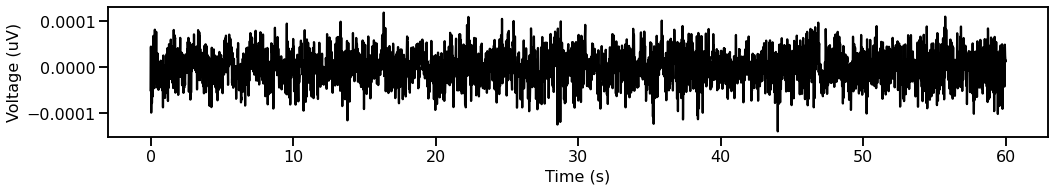

In [16]:
# Plot an example time series (full time)
plot_time_series(times, data[ind, :])

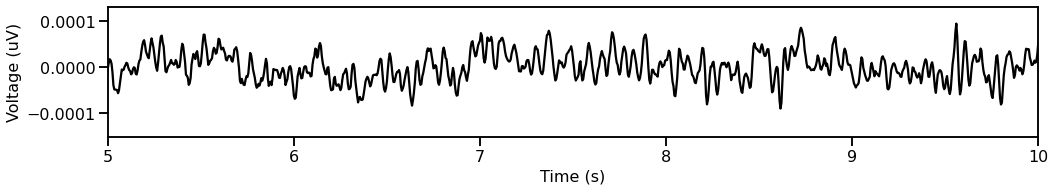

In [17]:
# Plot a zoomed in segment of a time series
plot_time_series(times, data[ind, :], xlim=[5, 10])

In [18]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[ind, :], fs, nperseg=2*fs, noverlap=fs)

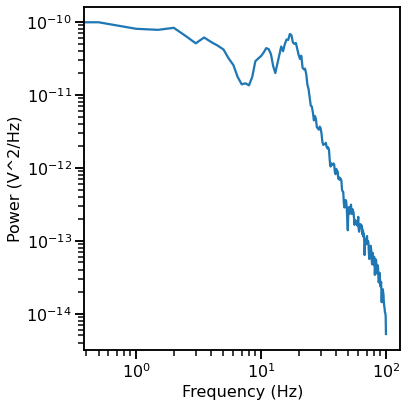

In [19]:
plot_power_spectra(freqs, powers)

## Compare Methods

In [20]:
# Settings for spectral parameterization
f_range = [3, 55]

In [21]:
# Initialize specparam model
fm = FOOOF(verbose=False)

In [22]:
# Define measures to apply
measures = {
    specparam : {'fs' : fs, 'f_range' : f_range},
    irasa : {'fs' : fs, 'f_range' : f_range},
    #hurst : {'fs' : fs},
    #dfa : {'fs' : fs},
    lempelziv : {},
    hjorth_complexity : {},
    app_entropy : {}
}

In [23]:
# Initialize outputs
outputs = {func.__name__ : np.zeros(n_chans) for func in measures.keys()}

In [24]:
# Calculate measures on data
for ind, sig in enumerate(all_data):
    for measure, params in measures.items():
        outputs[measure.__name__][ind] = measure(sig, **params)     

#### Compare exponent measures

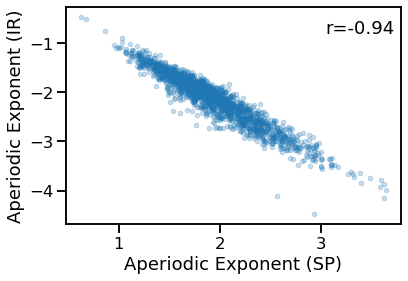

In [25]:
# Compare aperiodic exponent from specparam & IRASA
plot_dots(outputs['specparam'], outputs['irasa'], alpha=0.25,
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)')

In [26]:
sp_ir_corrs = bootstrap_corr(outputs['specparam'], outputs['irasa'])
print('  SP & IR:  ', format_corr(*sp_ir_corrs))

  SP & IR:   r=-0.943  CI[-0.950, -0.936],  p=0.000


#### Compare exponent to other measures

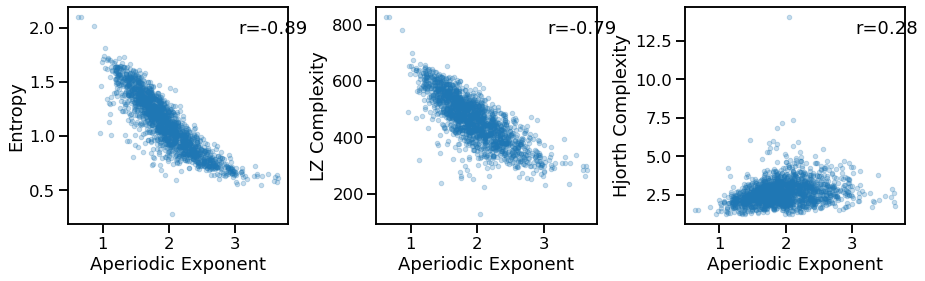

In [27]:
# Comparisons of aperiodic exponent to other measures
_, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_dots(outputs['specparam'], outputs['app_entropy'], alpha=0.25,
          xlabel='Aperiodic Exponent', ylabel='Entropy', ax=axes[0])
plot_dots(outputs['specparam'], outputs['lempelziv'], alpha=0.25,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity', ax=axes[1])
plot_dots(outputs['specparam'], outputs['hjorth_complexity'], alpha=0.25,
          xlabel='Aperiodic Exponent', ylabel='Hjorth Complexity', ax=axes[2])
plt.subplots_adjust(wspace=0.4)

In [28]:
sp_ent_corrs = bootstrap_corr(outputs['specparam'], outputs['app_entropy'])
print('  EXP & ENT:  ', format_corr(*sp_ent_corrs))
sp_lzc_corrs = bootstrap_corr(outputs['specparam'], outputs['lempelziv'])
print('  EXP & LZC:  ', format_corr(*sp_lzc_corrs))
sp_hcx_corrs = bootstrap_corr(outputs['specparam'], outputs['hjorth_complexity'])
print('  EXP & HCX:  ', format_corr(*sp_hcx_corrs))

  EXP & ENT:   r=-0.886  CI[-0.898, -0.872],  p=0.000
  EXP & LZC:   r=-0.790  CI[-0.810, -0.767],  p=0.000
  EXP & HCX:   r=+0.277  CI[+0.232, +0.320],  p=0.000


#### Compare entropy to other measures

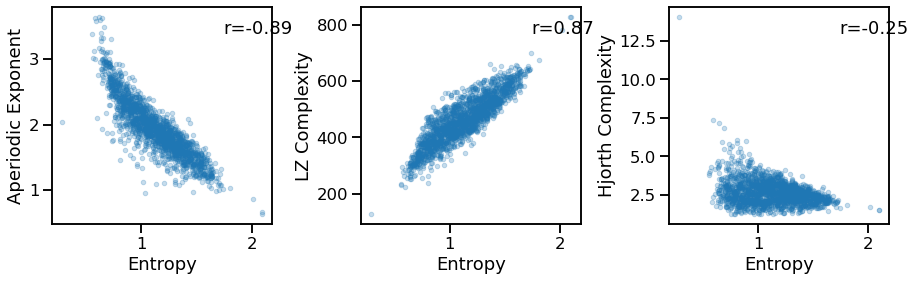

In [29]:
# Comparisons of entropy to other measures
_, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_dots(outputs['app_entropy'], outputs['specparam'], alpha=0.25,
          xlabel='Entropy', ylabel='Aperiodic Exponent', ax=axes[0])
plot_dots(outputs['app_entropy'], outputs['lempelziv'], alpha=0.25,
          xlabel='Entropy', ylabel='LZ Complexity', ax=axes[1])
plot_dots(outputs['app_entropy'], outputs['hjorth_complexity'], alpha=0.25,
          xlabel='Entropy', ylabel='Hjorth Complexity', ax=axes[2])
plt.subplots_adjust(wspace=0.4)

In [30]:
ent_exp_corrs = bootstrap_corr(outputs['app_entropy'], outputs['specparam'])
print('  ENT & EXP:  ', format_corr(*ent_exp_corrs))
ent_lpz_corrs = bootstrap_corr(outputs['app_entropy'], outputs['lempelziv'])
print('  ENT & LPZ:  ', format_corr(*ent_lpz_corrs))
ent_hcx_corrs = bootstrap_corr(outputs['app_entropy'], outputs['hjorth_complexity'])
print('  ENT & HCX:  ', format_corr(*ent_hcx_corrs))

  ENT & EXP:   r=-0.886  CI[-0.898, -0.871],  p=0.000
  ENT & LPZ:   r=+0.869  CI[+0.855, +0.882],  p=0.000
  ENT & HCX:   r=-0.254  CI[-0.297, -0.210],  p=0.000


#### Compare LZ complexity to other measures

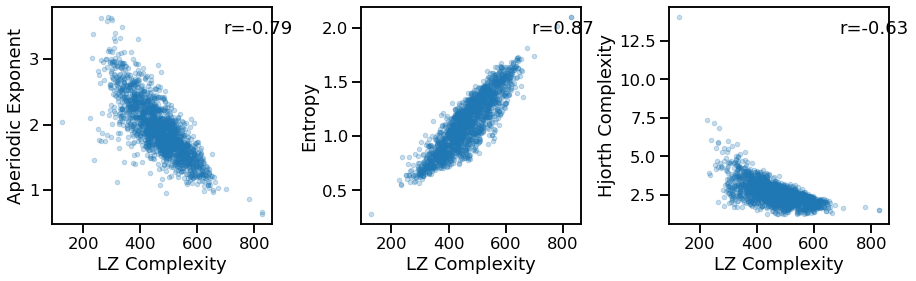

In [31]:
# Comparisons of LZ complexity to other measures
_, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_dots(outputs['lempelziv'], outputs['specparam'], alpha=0.25,
          xlabel='LZ Complexity', ylabel='Aperiodic Exponent', ax=axes[0])
plot_dots(outputs['lempelziv'], outputs['app_entropy'], alpha=0.25,
          xlabel='LZ Complexity', ylabel='Entropy', ax=axes[1])
plot_dots(outputs['lempelziv'], outputs['hjorth_complexity'], alpha=0.25,
          xlabel='LZ Complexity', ylabel='Hjorth Complexity', ax=axes[2])
plt.subplots_adjust(wspace=0.4)

In [33]:
lpz_exp_corrs = bootstrap_corr(outputs['lempelziv'], outputs['specparam'])
print('  LPZ & EXP:  ', format_corr(*sp_ir_corrs))
lpz_ent_corrs = bootstrap_corr(outputs['lempelziv'], outputs['app_entropy'])
print('  LPZ & ENT:  ', format_corr(*sp_ir_corrs))
lpz_hcx_corrs = bootstrap_corr(outputs['lempelziv'], outputs['hjorth_complexity'])
print('  LPZ & HCX:  ', format_corr(*sp_ir_corrs))

  LPZ & EXP:   r=-0.943  CI[-0.950, -0.936],  p=0.000
  LPZ & ENT:   r=-0.943  CI[-0.950, -0.936],  p=0.000
  LPZ & HCX:   r=-0.943  CI[-0.950, -0.936],  p=0.000


#### Compare Hjorth complexity to other measures

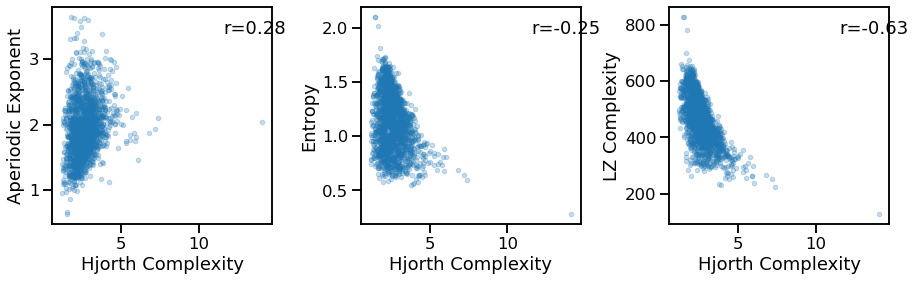

In [34]:
# Comparisons of Hjorth complexity to other measures
_, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_dots(outputs['hjorth_complexity'], outputs['specparam'], alpha=0.25,
          xlabel='Hjorth Complexity', ylabel='Aperiodic Exponent', ax=axes[0])
plot_dots(outputs['hjorth_complexity'], outputs['app_entropy'], alpha=0.25,
          xlabel='Hjorth Complexity', ylabel='Entropy', ax=axes[1])
plot_dots(outputs['hjorth_complexity'], outputs['lempelziv'], alpha=0.25,
          xlabel='Hjorth Complexity', ylabel='LZ Complexity', ax=axes[2])
plt.subplots_adjust(wspace=0.4)

In [35]:
sp_ir_corrs = bootstrap_corr(outputs['hjorth_complexity'], outputs['specparam'])
print('  SP & IR:  ', format_corr(*sp_ir_corrs))
sp_ir_corrs = bootstrap_corr(outputs['hjorth_complexity'], outputs['app_entropy'])
print('  SP & IR:  ', format_corr(*sp_ir_corrs))
sp_ir_corrs = bootstrap_corr(outputs['hjorth_complexity'], outputs['lempelziv'])
print('  SP & IR:  ', format_corr(*sp_ir_corrs))

  SP & IR:   r=+0.277  CI[+0.234, +0.320],  p=0.000
  SP & IR:   r=-0.254  CI[-0.298, -0.210],  p=0.000
  SP & IR:   r=-0.631  CI[-0.660, -0.600],  p=0.000


## Conclusions

Words, words, words.